# 3.2 线性回归的从零开始实现

In [2]:
# 只利用Tensor和autograd来实现一个线性回归的训练
 # 将那些用matplotlib绘制的图显示在页面里而不是弹出一个窗口
%matplotlib inline                   
import torch
from IPython import display           # 设置矢量图 display.set_matplotlib_formats('svg')
from matplotlib import pyplot as plt  # plt.scatter()画图，plt.rcParams['figure.figsize'] 设置图片大小
import numpy as np                    # np.random.normal()产生正态随机噪声 
import random                         # 用random.shuffle随机排序

print(torch.__version__)

1.4.0


## 3.2.1 生成数据集

In [3]:
# 构造Y = XW + b + e，e为噪声项
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
# 产生1000x2的特征向量
features = torch.randn(num_examples, num_inputs,
                      dtype=torch.float32)     
# 生成标签，加上均值为0，方差0.01的噪声
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b 
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [18]:
print(features[0], labels[0]) # feature每行2个特征x1和x2，label为列向量
labels.shape

tensor([-0.5329,  0.2060]) tensor(2.4480)


torch.Size([1000])

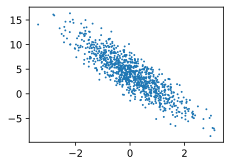

In [17]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# # 在../d2lzh_pytorch里面添加上面两个函数后就可以这样导入
# import sys
# sys.path.append("..")
# from d2lzh_pytorch import * 

set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 3.2.2 读取数据

In [18]:
# 本函数已保存在d2lzh包中方便以后使用
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples)) # 把迭代器转成0到n-1的list
    random.shuffle(indices)  # 将元素随机排序
    for i in range(0, num_examples, batch_size):
        # Longtensor 64bit整型
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # min：最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j) # 生成器，返回当前j个特征和标签

In [6]:
batch_size = 10 # 定义batch大小

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y) # 打印前10个
    break

tensor([[-1.7375,  0.3901],
        [-0.8704, -0.9585],
        [ 1.9043,  0.7015],
        [ 0.3837,  1.3789],
        [-1.2878, -1.2678],
        [ 0.0898,  0.8221],
        [ 1.1716,  2.1854],
        [-0.8191,  1.0926],
        [-2.3496, -1.2331],
        [-0.2731,  1.6476]]) 
 tensor([-0.5916,  5.7119,  5.6212,  0.2778,  5.9195,  1.5870, -0.8959, -1.1504,
         3.6786, -1.9714])


## 3.2.3 初始化模型参数

In [22]:
# 正态分布初始化参数w，b=1
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [23]:
# 求梯度requires_grad=True
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 3.2.4 定义模型

In [24]:
# 定义线性回归，矩阵乘法加常数
def linreg(X, w, b):  # 本函数已保存在d2lzh包中方便以后使用
    return torch.mm(X, w) + b

## 3.2.5 定义损失函数

In [21]:
# 平方误差函数
# 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
def squared_loss(y_hat, y):  # 本函数已保存在pytorch_d2lzh包中方便以后使用
    return (y_hat - y.view(y_hat.size())) ** 2 / 2


tensor(0.1121)

## 3.2.6 定义优化算法

In [26]:
# 小批量随机梯度下降
def sgd(params, lr, batch_size):  # 本函数已保存在d2lzh_pytorch包中方便以后使用
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data

## 3.2.7 训练模型

In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.044079
epoch 2, loss 0.000175
epoch 3, loss 0.000049


In [28]:
# 比较训练的参数和真实值
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9999],
        [-3.3989]], requires_grad=True)
4.2 
 tensor([4.1990], requires_grad=True)
